In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import keras
from keras_preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.resnet import ResNet50, preprocess_input, decode_predictions
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [2]:
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config = config)

In [3]:
path = 'C:/Users/thats/Desktop/IoT/datasets/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'
path_train = path+'/train'
path_val = path+'/valid'
classes_train = len(os.listdir(path_train))
classes_val = len(os.listdir(path_val))
print(classes_train,classes_val)

38 38


In [4]:
#preprocessing data generating
train_generator = ImageDataGenerator(
    zoom_range=0.75,
    shear_range=0.3,
    horizontal_flip=True,
    preprocessing_function=preprocess_input
)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [5]:
train = train_generator.flow_from_directory(
    directory=path_train,
    target_size=(224,224),
    batch_size=32
)
val = val_generator.flow_from_directory(
    directory=path_val,
    target_size=(224,224),
    batch_size=32
)

Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [6]:
def plotImage(imgArr, label):
    for image, lab in zip(imgArr,label):
        plt.figure(figsize=(5,5))
        plt.imshow(image)
        plt.show()

In [7]:
train_img, label = train.next()
train_img.shape

(32, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


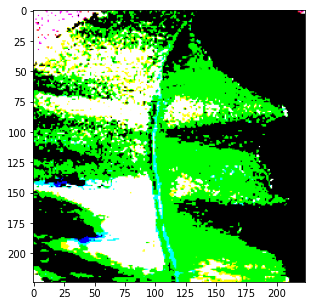

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


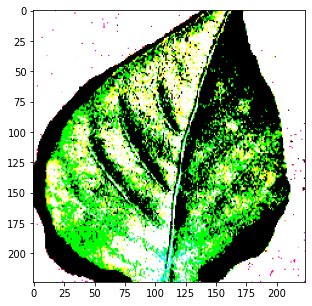

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


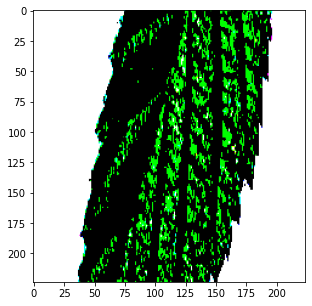

In [8]:
plotImage(train_img[:3], label[:3])

In [9]:
#model
base_model = ResNet50(
    input_shape=(224,224,3),
    include_top=False
) 

In [10]:
#refrain model from retraining again and again
for layers in base_model.layers:
    layers.trainable = False

In [11]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
X = Flatten()(base_model.output)

X = Dense(units = 38, activation='softmax')(X)

#final modelling
model = Model(base_model.input, X)

In [13]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [14]:
model.compile(optimizer='adam',loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [15]:
#early stopping
es = EarlyStopping(
    monitor='val_accuracy', 
    min_delta=0, 
    patience=3, 
    verbose=1,
    mode='auto'
)

#model check points
mc = ModelCheckpoint(
    filepath="best_model.h5",
    monitor='val_accuracy',
    # min_delta= 0.01,
    patience= 3,
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    # period=1
)

# callbacks
cb = [es,mc]

In [71]:
history = model.fit(
    train,
    epochs=20,
    steps_per_epoch=200,
    verbose=1, 
    callbacks=cb,
    validation_data=val,
    # validation_steps=16
)

Epoch 1/20
200/200 [==============================] - ETA: 0s - loss: 13.5470 - accuracy: 0.5614
Epoch 1: val_accuracy improved from -inf to 0.81340, saving model to best_model.h5
200/200 [==============================] - 1904s 10s/step - loss: 13.5470 - accuracy: 0.5614 - val_loss: 4.4065 - val_accuracy: 0.8134
Epoch 2/20
200/200 [==============================] - ETA: 0s - loss: 9.5125 - accuracy: 0.7245
Epoch 2: val_accuracy improved from 0.81340 to 0.82967, saving model to best_model.h5
200/200 [==============================] - 2000s 10s/step - loss: 9.5125 - accuracy: 0.7245 - val_loss: 5.8313 - val_accuracy: 0.8297
Epoch 3/20
200/200 [==============================] - ETA: 0s - loss: 7.4938 - accuracy: 0.7875
Epoch 3: val_accuracy improved from 0.82967 to 0.86826, saving model to best_model.h5
200/200 [==============================] - 2015s 10s/step - loss: 7.4938 - accuracy: 0.7875 - val_loss: 4.1609 - val_accuracy: 0.8683
Epoch 4/20
200/200 [==============================] -

In [19]:
#load best model
b_model = load_model('C:/Users/thats/Desktop/IoT/best_model.h5')

In [21]:
acc = b_model.evaluate_generator(val)[1]
print('The accuracy of model is:',acc*100,'%')

C:\Users\thats\AppData\Local\Temp\ipykernel_26412\2224829846.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  acc = b_model.evaluate_generator(val)[1]


The accuracy of model is: 92.75552034378052 %


In [39]:
label = dict(zip(list(train.class_indices.values()),list(train.class_indices.keys())))
label

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [33]:
def prediction(path):
    img = load_img(path, target_size=(224,224))
    i = img_to_array(img)

    im = preprocess_input(i)
    img = np.expand_dims(i, axis=0)

    pred = np.argmax(b_model.predict(img))

    print(label[pred])

In [34]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/AppleCedarRust1.JPG'

prediction(path)

1/1 [==============================] - 0s 141ms/step
Apple___Cedar_apple_rust


In [35]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/CornCommonRust2.JPG'

prediction(path)

1/1 [==============================] - 0s 137ms/step
Corn_(maize)___Common_rust_


In [36]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/PotatoEarlyBlight4.JPG'

prediction(path)

1/1 [==============================] - 0s 157ms/step
Potato___Late_blight


In [37]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/PotatoEarlyBlight2.JPG'

prediction(path)

1/1 [==============================] - 0s 185ms/step
Potato___Late_blight


In [38]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/TomatoYellowCurlVirus4.JPG'

prediction(path)

1/1 [==============================] - 0s 124ms/step
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [41]:
path = 'C:/Users/thats/Desktop/IoT/datasets/test/test/PotatoHealthy2.JPG'

prediction(path)

1/1 [==============================] - 0s 161ms/step
Potato___healthy
